In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1Qt8cfd-mPgHA6FZxP_DcsLfMa5V0aY9V'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('mnist_test.csv')

file_id = '1o_aOa12WGHrHF7KkBc8KpK8jDyDEA5QS'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('mnist_train.csv')

In [0]:
import pandas as pd

train_dataset = pd.read_csv('mnist_train.csv')
test_dataset = pd.read_csv('mnist_test.csv')

In [4]:
train_dataset.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
del test_dataset['label']

In [28]:
test_dataset.head()

,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,2x12,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Split to Image & Label
train_images = (train_dataset.iloc[:, 1:].values).astype("float32")
train_labels = train_dataset["label"].values
test_images = (test_dataset.values).astype("float32")

In [30]:
train_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
train_labels

array([5, 0, 4, ..., 5, 6, 8])

In [32]:
test_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, 
                                                                          train_labels, 
                                                                          stratify = train_labels, 
                                                                          random_state = 42, 
                                                                          test_size = 0.2)

In [34]:
print('train_images shape:',train_images.shape)
print('valid_images shape:',valid_images.shape)
print('test_images shape', test_images.shape)

train_images shape: (48000, 784)
valid_images shape: (12000, 784)
test_images shape (10000, 784)


In [35]:
print('train_labels shape:', train_labels.shape)
print('valid_labels shape:', valid_labels.shape)

train_labels shape: (48000,)
valid_labels shape: (12000,)


In [0]:
# Reshape image's size to check for ours
train_images = train_images.reshape(train_images.shape[0], 28, 28)
valid_images = valid_images.reshape(valid_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

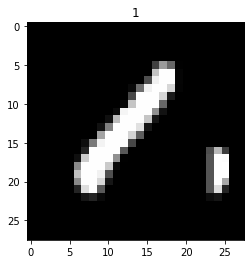

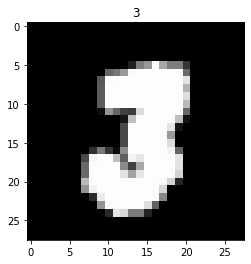

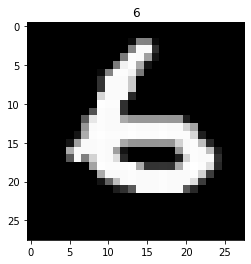

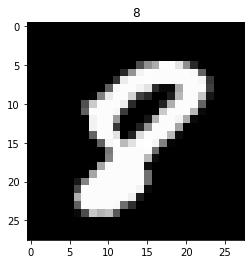

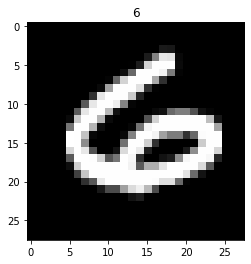

In [38]:
import matplotlib.pyplot as plt
for idx in range(0, 5):
  plt.imshow(train_images[idx], cmap=plt.get_cmap('gray'))
  plt.title(train_labels[idx])
  plt.show()

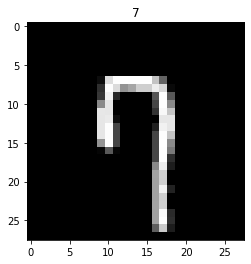

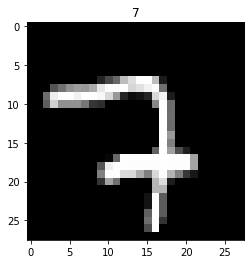

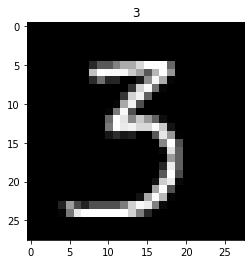

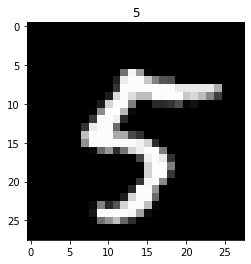

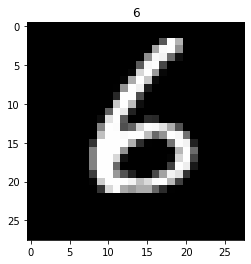

In [40]:
for idx in range(0, 5):
  plt.imshow(valid_images[idx], cmap = plt.get_cmap('gray'))
  plt.title(valid_labels[idx])
  plt.show()

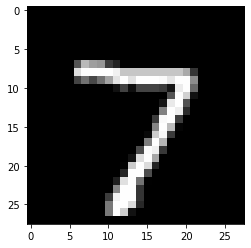

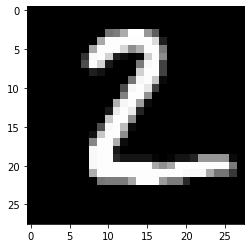

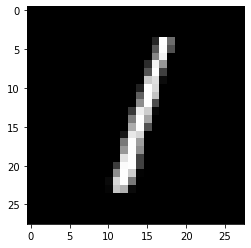

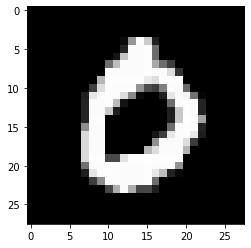

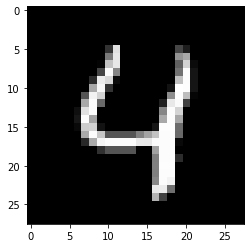

In [41]:
for idx in range(0, 5):
  plt.imshow(test_images[idx], cmap = plt.get_cmap('gray'))
  plt.show()

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_images_tensor = torch.tensor(train_images)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_tensor, batch_size=64, num_workers=0, shuffle=True)

valid_images_tensor = torch.tensor(valid_images)
valid_labels_tensor = torch.tensor(valid_labels)
valid_tensor = TensorDataset(valid_images_tensor, valid_labels_tensor)
valid_loader = DataLoader(valid_tensor, batch_size = 64, num_workers = 0, shuffle=True)

test_images_tensor = torch.tensor(test_images)

In [46]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.input_layer = nn.Linear(28 * 28, 128)
    self.hidden_layer = nn.Linear(128, 128)
    self.output_layer = nn.Linear(128, 10)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_layer(x))
    x = self.output_layer(x)
    x = F.log_softmax(x, dim = 1)
    return x

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

model = MLP().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

print('Model:', model)
print('Device:', DEVICE)

Model: MLP(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (hidden_layer): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Device: cpu


In [0]:
def train(model, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)\tLoss:{:.6f}]'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()
      ))

def evaluate(model, valid_loader):
  model.eval()
  valid_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in valid_loader:
      data, target = data.to(DEVICE), target.to(DEVICE)
      output = model(data)
      valid_loss += F.cross_entropy(output, target, reduction='sum').item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(target.view_as(prediction)).sum().item()

  valid_loss /= len(valid_loader.dataset)
  valid_accuracy = 100. * correct / len(valid_loader.dataset)
  return valid_loss, valid_accuracy

In [48]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  valid_loss, valid_accuracy = evaluate(model, valid_loader)
  print('[EPOCH: {}], \tValidation Loss: {:.4f}, \tValidation Accuracy: {:.2f} %\n'.format(
      epoch, valid_loss, valid_accuracy
  ))

Train Epoch: 1 [0/48000 (0%)	Loss:13.072005]
Train Epoch: 1 [6400/48000 (13%)	Loss:0.418819]
Train Epoch: 1 [12800/48000 (27%)	Loss:0.315316]
Train Epoch: 1 [19200/48000 (40%)	Loss:0.348619]
Train Epoch: 1 [25600/48000 (53%)	Loss:0.280525]
Train Epoch: 1 [32000/48000 (67%)	Loss:0.176338]
Train Epoch: 1 [38400/48000 (80%)	Loss:0.256163]
Train Epoch: 1 [44800/48000 (93%)	Loss:0.224963]
[EPOCH: 1], 	Validation Loss: 0.2037, 	Validation Accuracy: 94.33 %

Train Epoch: 2 [0/48000 (0%)	Loss:0.121219]
Train Epoch: 2 [6400/48000 (13%)	Loss:0.152646]
Train Epoch: 2 [12800/48000 (27%)	Loss:0.121382]
Train Epoch: 2 [19200/48000 (40%)	Loss:0.283081]
Train Epoch: 2 [25600/48000 (53%)	Loss:0.044829]
Train Epoch: 2 [32000/48000 (67%)	Loss:0.113339]
Train Epoch: 2 [38400/48000 (80%)	Loss:0.039782]
Train Epoch: 2 [44800/48000 (93%)	Loss:0.061112]
[EPOCH: 2], 	Validation Loss: 0.1662, 	Validation Accuracy: 95.16 %

Train Epoch: 3 [0/48000 (0%)	Loss:0.091045]
Train Epoch: 3 [6400/48000 (13%)	Loss:0.10000

In [0]:
def testset_prediction(model, test_images_tensor):
  model.eval()
  result = []
  with torch.no_grad():
    for data in test_images_tensor:
      data = data.to(DEVICE)
      output = model(data)
      prediction = output.max(1, keepdim = True)[1]
      result.append(prediction.tolist())
  return result

In [52]:
test_predict_result = testset_prediction(model, test_images_tensor)
test_predict_result[:5]

[[[7]], [[2]], [[1]], [[0]], [[4]]]

In [53]:
import numpy as np
from collections import Counter
Counter(np.squeeze(test_predict_result)).most_common()

[(1, 1154),
 (3, 1088),
 (4, 1069),
 (0, 1043),
 (7, 1017),
 (2, 1001),
 (8, 958),
 (6, 910),
 (5, 886),
 (9, 874)]

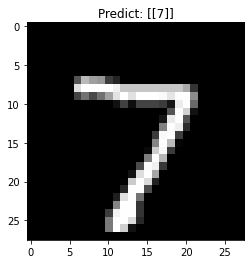

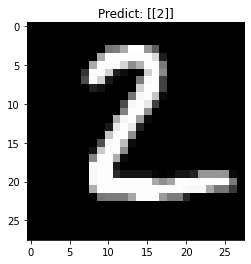

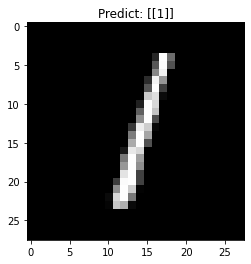

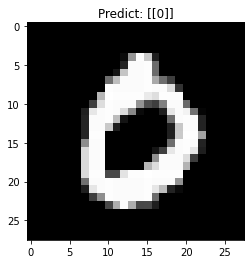

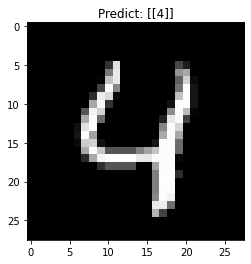

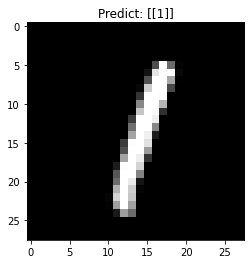

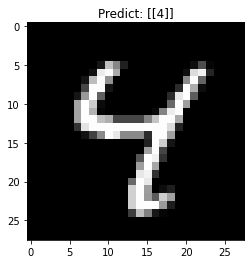

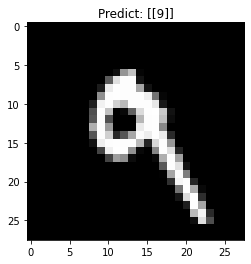

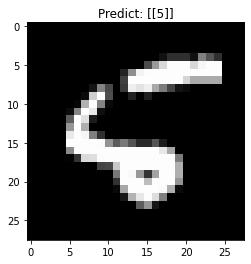

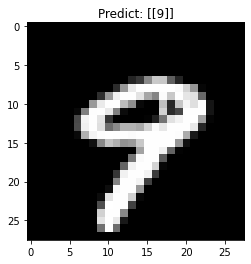

In [54]:
for idx in range(0, 10):
  plt.imshow(test_images[idx], cmap=plt.get_cmap('gray'))
  plt.title('Predict: ' + str(test_predict_result[idx]))
  plt.show()